In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
train_inputs = np.array([-40,-20,-10,0,1,30,100])
train_labels = np.array([-40,-4,14,32,33.8,86,212])


test_inputs = np.array([50,200])
test_labels = np.array([122,392])

In [ ]:
layer = tf.keras.layers.Dense(1,input_shape=(1,))
model = tf.keras.Sequential(layer)
model.compile(optimizer=tf.keras.optimizers.Adam(0.2), loss="mse" )
history = model.fit(train_inputs,train_labels,epochs=1000, shuffle=True)

Epoch 1/1000
1/1 [==============================] - 1s 524ms/step - loss: 20267.8340
Epoch 2/1000
1/1 [==============================] - 0s 13ms/step - loss: 17925.3926
Epoch 3/1000
1/1 [==============================] - 0s 10ms/step - loss: 15737.6387
Epoch 4/1000
1/1 [==============================] - 0s 7ms/step - loss: 13706.8594
Epoch 5/1000
1/1 [==============================] - 0s 11ms/step - loss: 11834.7334
Epoch 6/1000
1/1 [==============================] - 0s 12ms/step - loss: 10122.1172
Epoch 7/1000
1/1 [==============================] - 0s 7ms/step - loss: 8569.0068
Epoch 8/1000
1/1 [==============================] - 0s 8ms/step - loss: 7174.4233
Epoch 9/1000
1/1 [==============================] - 0s 7ms/step - loss: 5936.2759
Epoch 10/1000
1/1 [==============================] - 0s 5ms/step - loss: 4851.2881
Epoch 11/1000
1/1 [==============================] - 0s 6ms/step - loss: 3914.8977
Epoch 12/1000
1/1 [==============================] - 0s 4ms/step - loss: 3121.2046
E

Text(0, 0.5, 'Loss')

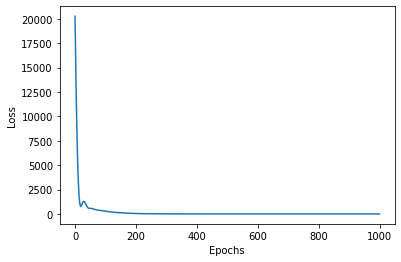

In [ ]:
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [ ]:
model.predict([50])[0][0]

121.999985

In [ ]:
layer.get_weights()

[array([[1.8000002]], dtype=float32), array([31.999975], dtype=float32)]

In [ ]:
!pip install nengo_dl nengo

     |████████████████████████████████| 284 kB 25.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 523 kB 28.1 MB/s 
  Created wheel for nengo-dl: filename=nengo_dl-3.4.3-py3-none-any.whl size=205217 sha256=62f066e16ebd6c6d621b4de6b9159f656f1f75351193119c8a428ce3ae441767
  Stored in directory: /root/.cache/pip/wheels/f8/9f/d7/05a384373b7813864be0052888ab464b46b1f425634e6fe925
Successfully built nengo-dl
  Attempting uninstall: progressbar2
    Found existing installation: progressbar2 3.38.0
    Uninstalling progressbar2-3.38.0:
      Successfully uninstalled progressbar2-3.38.0


In [ ]:
import nengo
import nengo_dl

In [ ]:
with nengo.Network(seed=0) as net:
    # set some default parameters for the neurons that will make
    # the training progress more smoothly
    net.config[nengo.Ensemble].max_rates = nengo.dists.Choice([100])
    net.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    net.config[nengo.Connection].synapse = None
    neuron_type = nengo.LIF(amplitude=0.01)

    # this is an optimization to improve the training speed,
    # since we won't require stateful behaviour in this example
    nengo_dl.configure_settings(stateful=False)

    # the input node that will be used to feed in input data
    inp = nengo.Node(np.zeros(1,))

    # add the layer
    out = nengo_dl.Layer(tf.keras.layers.Dense(1,input_shape=(1,)))(inp)

    # we'll create two different output probes, one with a filter
    # (for when we're simulating the network over time and
    # accumulating spikes), and one without (for when we're
    # training the network using a rate-based approximation)
    out_p = nengo.Probe(out, label="out_p")
    out_p_filt = nengo.Probe(out, synapse=0.1, label="out_p_filt")


In [ ]:
minibatch_size = 1
sim = nengo_dl.Simulator(net, minibatch_size=minibatch_size)

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
|             Constructing graph: build stage (0%)             | ETA:  --:--:--

/usr/local/lib/python3.7/dist-packages/nengo_dl/simulator.py:461: UserWarning: No GPU support detected. See https://www.nengo.ai/nengo-dl/installation.html#installing-tensorflow for instructions on setting up TensorFlow with GPU support.
  "No GPU support detected. See "


Construction finished in 0:00:00                                               


In [ ]:
train_inputs = np.array([-40,-20,-10,0,1,30,100])
train_labels = np.array([-40,-4,14,32,33.8,86,212])


test_inputs = np.array([50,200])
test_labels = np.array([122,392])

In [ ]:
# add single timestep to training data
train_inputs = train_inputs[:, None,None]
train_labels = train_labels[:, None,None]

# when testing our network with spiking neurons we will need to run it
# over time, so we repeat the input/target data for a number of
# timesteps.
n_steps = 500
test_inputs = np.tile(test_inputs[:, None,None], (1, n_steps,1))
test_labels = np.tile(test_labels[:, None,None], (1, n_steps,1))

In [ ]:
test_labels.shape

(2, 500, 1)

In [ ]:
train_inputs[0]

array([[-40]])

In [ ]:
def classification_mse(y_true, y_pred):
    print(y_pred.shape)
    return tf.keras.metrics.mean_squared_error(y_true[:, -1], y_pred[:, -1])


# note that we use `out_p_filt` when testing (to reduce the spike noise)
sim.compile(loss={out_p_filt: classification_mse})
print(
    "MSE before training:",
    sim.evaluate(test_inputs, {out_p_filt: test_labels}, verbose=0)["loss"],
)

(1, None, 1)
(1, None, 1)
MSE before training: 209836.328125


In [ ]:

# run training
sim.compile(
    optimizer=tf.keras.optimizers.Adam(0.2),
    loss={out_p: tf.keras.losses.MeanSquaredError()},
)
history_snn = sim.fit(train_inputs, {out_p: train_labels}, epochs=100)


Epoch 1/100
|############Constructing graph: build stage (100%)############| ETA:  00:00:00

/usr/local/lib/python3.7/dist-packages/nengo_dl/simulator.py:2101: RuntimeWarning: Simulator with model=Model: <Network (unlabeled) at 0x7f55e5cccf10>, dt=0.001000 was deallocated while open. Simulators should be closed manually to ensure resources are properly freed.
  RuntimeWarning,


7/7 [==============================] - 2s 3ms/step - loss: 13781.3281 - out_p_loss: 13781.3281
Epoch 2/100
7/7 [==============================] - 0s 3ms/step - loss: 9299.8184 - out_p_loss: 9299.8184
Epoch 3/100
7/7 [==============================] - 0s 3ms/step - loss: 3620.7576 - out_p_loss: 3620.7576
Epoch 4/100
7/7 [==============================] - 0s 3ms/step - loss: 2187.0166 - out_p_loss: 2187.0166
Epoch 5/100
7/7 [==============================] - 0s 3ms/step - loss: 1194.5865 - out_p_loss: 1194.5865
Epoch 6/100
7/7 [==============================] - 0s 4ms/step - loss: 879.8444 - out_p_loss: 879.8444
Epoch 7/100
7/7 [==============================] - 0s 4ms/step - loss: 769.3861 - out_p_loss: 769.3861
Epoch 8/100
7/7 [==============================] - 0s 4ms/step - loss: 784.3060 - out_p_loss: 784.3060
Epoch 9/100
7/7 [==============================] - 0s 3ms/step - loss: 768.5482 - out_p_loss: 768.5482
Epoch 10/100
7/7 [==============================] - 0s 3ms/step - loss: 7

Text(0, 0.5, 'Loss')

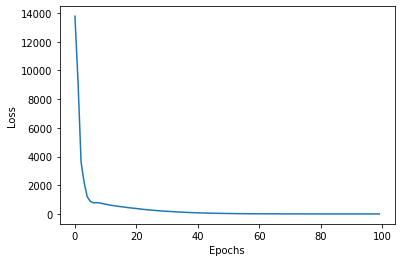

In [ ]:
plt.plot(history_snn.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


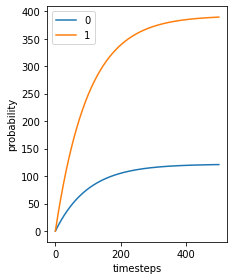

In [ ]:
data = sim.predict(test_inputs)
for i in range(2):

    plt.subplot(1, 2, 2)
    plt.plot(data[out_p_filt][i])
    plt.legend([str(i) for i in range(10)], loc="upper left")
    plt.xlabel("timesteps")
    plt.ylabel("probability")
    plt.tight_layout()

In [ ]:
test_labels[0,-1]

array([122])

In [ ]:
data[out_p_filt][0,-1]

array([121.04798], dtype=float32)

In [ ]:
out.tensor_func.get_weights()

[array([[1.800988]], dtype=float32), array([31.828186], dtype=float32)]

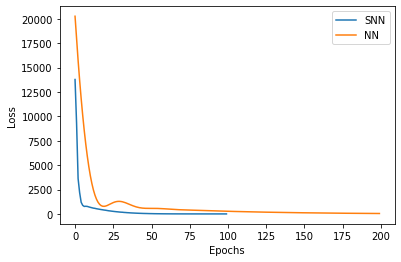

In [ ]:
plt.plot(history_snn.history['loss'],label="SNN")
plt.plot(history.history['loss'][:200],label="NN")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()